In [1]:
from typing import Annotated, Literal, TypedDict

from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END,START,StateGraph,MessagesState
from langgraph.prebuilt import ToolNode

import requests
from api_key import GAODE_WEATHER_API_KEY
@tool
def get_weather(city_name:str)->dict:
    '''According to the entered city name, use Autonavi interface to check the local weather today and the next 3 days'''
    # 构建请求URL
    url = f'https://restapi.amap.com/v3/weather/weatherInfo?key={GAODE_WEATHER_API_KEY}&city={city_name}&extensions=all'
    
    try:
        # 发送GET请求
        response = requests.get(url)
        # 检查请求是否成功
        if response.status_code == 200:
            # 解析响应内容
            data = response.json()
            # 检查API响应状态
            if data.get('status') == '1' and data.get('infocode') == '10000':
                return data  # 返回天气数据
            else:
                return {}  # 返回空结果，因为API返回了错误信息
        else:
            return {}  # 返回空结果，因为HTTP状态码不是200
    except Exception as e:
        print(f"An error occurred: {e}")
        return {}  # 返回空结果，因为请求过程中发生了异常

@tool
def plot_line(json_data:str,requirement:str)->None:
    ''' 根据输入的json数据和需求，绘制出折线图
    json_data: 待绘制的数据
    requirement：绘制需求
    '''
    from langchain.prompts import PromptTemplate
    template="""
    已知以下由单引号分隔的json内容，根据用户问题生成Python脚本，
    要求输出可执行代码即可，不输出其他任何信息
    如果使用matplotlib绘制图形，使用plt.rcParams设置，确保中文输出不乱码
    '''
    {json_data}
    '''
    
    用户提问：{requirement}
    """
    prompt_template=PromptTemplate(template=template)
    
    def get_python_code(python_code:str)->str:
        # print(python_code)
        return python_code.content

    from langchain_experimental.utilities import PythonREPL
    python_repl=PythonREPL()
    chain=prompt_template|model|get_python_code|PythonREPL().run
    
    chain.invoke(
        input={"json_data":json_data,"requirement":'将每一天的白天温度绘制成折线图'},
    ) 

from langchain_ollama import ChatOllama
model=ChatOllama(model="qwen2.5:latest",base_url='http://192.168.3.155:11434')

# 您可以创建一个工具来传递给一个代理
from langchain.agents import Tool
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool
tools=[get_weather,YahooFinanceNewsTool(),plot_line]

model=model.bind_tools(tools=tools)

tool_node=ToolNode(tools=tools)

# Define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

# Define the function that calls the model
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", 'agent')

# Initialize memory to persist state between graph runs
checkpointer = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable.
# Note that we're (optionally) passing the memory when compiling the graph
app = workflow.compile(checkpointer=checkpointer)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
# Use the Runnable
final_state = app.invoke(
    {"messages": [HumanMessage(content="你好，我叫小五，住在广州")]},
    config={"configurable": {"thread_id": 42}}
)
# final_state["messages"][-1].content
final_state

{'messages': [HumanMessage(content='你好，我叫小五，住在广州', additional_kwargs={}, response_metadata={}, id='f5261e6d-ab99-43f1-8adf-27189e05c0d6'),
  AIMessage(content='你好，小五！很高兴认识你。你住在广州，想查询广州的天气情况吗？如果是的话，我可以帮你查一查。如果不是，请告诉我你需要什么帮助。', additional_kwargs={}, response_metadata={'model': 'qwen2.5:latest', 'created_at': '2024-12-06T06:06:44.950776232Z', 'message': {'role': 'assistant', 'content': '你好，小五！很高兴认识你。你住在广州，想查询广州的天气情况吗？如果是的话，我可以帮你查一查。如果不是，请告诉我你需要什么帮助。'}, 'done_reason': 'stop', 'done': True, 'total_duration': 617556969, 'load_duration': 31513466, 'prompt_eval_count': 349, 'prompt_eval_duration': 56014000, 'eval_count': 38, 'eval_duration': 377784000}, id='run-90c5fe8b-e78c-4f05-84fa-e63174665178-0', usage_metadata={'input_tokens': 349, 'output_tokens': 38, 'total_tokens': 387})]}

Python REPL can execute arbitrary code. Use with caution.


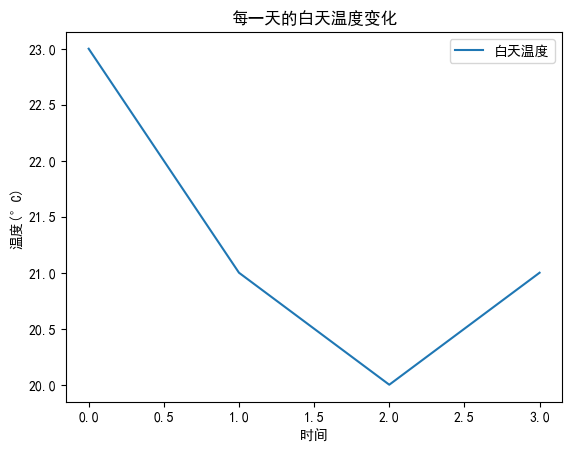

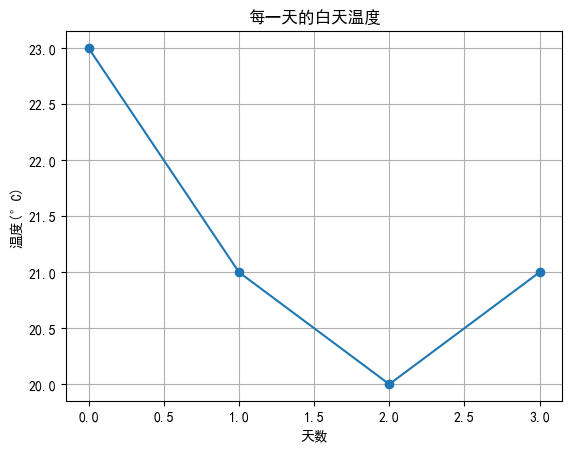

{'messages': [HumanMessage(content='你好，我叫小五，住在广州', additional_kwargs={}, response_metadata={}, id='f5261e6d-ab99-43f1-8adf-27189e05c0d6'),
  AIMessage(content='你好，小五！很高兴认识你。你住在广州，想查询广州的天气情况吗？如果是的话，我可以帮你查一查。如果不是，请告诉我你需要什么帮助。', additional_kwargs={}, response_metadata={'model': 'qwen2.5:latest', 'created_at': '2024-12-06T06:06:44.950776232Z', 'message': {'role': 'assistant', 'content': '你好，小五！很高兴认识你。你住在广州，想查询广州的天气情况吗？如果是的话，我可以帮你查一查。如果不是，请告诉我你需要什么帮助。'}, 'done_reason': 'stop', 'done': True, 'total_duration': 617556969, 'load_duration': 31513466, 'prompt_eval_count': 349, 'prompt_eval_duration': 56014000, 'eval_count': 38, 'eval_duration': 377784000}, id='run-90c5fe8b-e78c-4f05-84fa-e63174665178-0', usage_metadata={'input_tokens': 349, 'output_tokens': 38, 'total_tokens': 387}),
  HumanMessage(content='帮我查查天气，并且将白天气温以折线图输出', additional_kwargs={}, response_metadata={}, id='6bd7aa72-c34e-4256-b25e-6617b0b2c6d0'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.

In [3]:
# Use the Runnable
final_state = app.invoke(
    {"messages": [HumanMessage(content="帮我查查天气，并且将白天气温以折线图输出")]},
    config={"configurable": {"thread_id": 42}}
)
# final_state["messages"][-1].content
final_state

In [4]:
# Use the Runnable
final_state = app.invoke(
    {"messages": [HumanMessage(content="我是谁？")]},
    config={"configurable": {"thread_id": 42}}
)
final_state["messages"][-1].content

'你叫小五，刚才我们聊天时提到你住在广州，并且请求查询了广州的天气情况以及希望看到未来几天白天温度的变化折线图。如果你还有其他想知道的信息或者需要帮助的事情，请尽管告诉我！'

以上例子包含6个步骤：

1. **初始化模型及工具**：初始化llm，并且为llm绑定工具
2. **使用状态初始化图形**：通过传递 state schema 来初始化 graph （（在我们的例子中StateGraph(MessagesState)
3. **定义图形节点**：添加图形节点agent和tools
4. **定义入口及图形边缘**：首先设置了图形的入口(本例是agent)，然后添加正常边及条件边，条件边取决于图形状态
5. **编译图形**：编译图形，即将其自动转为Runnable，然后可以使用.invoke().stream().batch()输入，还可以选择checkpointer 对象，以便在图形运行之间持久保存状态，并启用内存、人机交互工作流程、时间旅行等
6. **执行**：（1）从START开始，LangGraph 将输入消息添加到内部 state，然后将 state 传递给agent;（2）调用llm后，将返回信息添加到AIMessage；(3)条件选择执行，是否调用工具；(4)直到到达图形的END端点

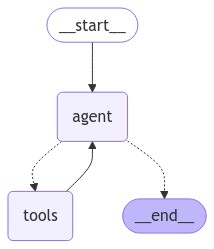

In [5]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)